In [1]:
# if you use gpu accelerator in kaggle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 1. Importing Libraries

In [6]:
import tensorflow as tf

from keras import optimizers, regularizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import requests

import cv2
import os
import pandas as pd

In [3]:
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0
: /physical_device:GPU:0


## 2. Gathering Data

In [10]:
# defining paths of train, validation and test data
train_path = "data/images/train"
valid_path = "data/images/valid"
test_path = "data/images/test"

In [11]:
image_shape = (350,350,3)
N_CLASSES = 2
BATCH_SIZE = 256

# loading training data and rescaling it using ImageDataGenerator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# loading validation data and rescaling it using ImageDataGenerator
valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# loading test data and rescaling it using ImageDataGenerator
test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


## 3. Building the model

In [6]:
# defining the coefficient that our regularizer will use
weight_decay = 1e-3

# building a sequential CNN model and adding layers to it
# dropout and the regularizer are used in general to prevent overfitting
first_model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])
# showing the summary of our model (layers and number of parameters)
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 349, 349, 8)       104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 174, 174, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 173, 173, 16)      528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 86, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 32)        0

## 4. Training the model

In [7]:
# don't stop everything if an image didn't load correctly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# checkpointer to save the model only if it improved
checkpointer = ModelCheckpoint('first_model.hdf5',verbose=1, save_best_only= True)
# early stopping to stop the training if our validation loss didn't decrease for (10) consecutive epochs
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
# Adam, best optimiser for deep learning models to help with the training
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
# setting our loss function and which metric to evaluate
first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer,
                    metrics=['AUC','acc'])

# TRAIN
history = first_model.fit(train_generator,
                    epochs = 50,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/50
119/119 [==============================] - 341s 3s/step - loss: 0.6599 - auc: 0.6735 - acc: 0.5938 - val_loss: 0.5619 - val_auc: 0.8529 - val_acc: 0.7595

Epoch 00001: val_loss improved from inf to 0.56190, saving model to first_model.hdf5
Epoch 2/50
119/119 [==============================] - 241s 2s/step - loss: 0.4874 - auc: 0.8889 - acc: 0.8120 - val_loss: 0.3920 - val_auc: 0.9356 - val_acc: 0.8646

Epoch 00002: val_loss improved from 0.56190 to 0.39204, saving model to first_model.hdf5
Epoch 3/50
119/119 [==============================] - 240s 2s/step - loss: 0.3747 - auc: 0.9335 - acc: 0.8664 - val_loss: 0.3128 - val_auc: 0.9565 - val_acc: 0.8970

Epoch 00003: val_loss improved from 0.39204 to 0.31283, saving model to first_model.hdf5
Epoch 4/50
119/119 [==============================] - 241s 2s/step - loss: 0.3176 - auc: 0.9508 - acc: 0.8857 - val_loss: 0.2778 - val_auc: 0.9636 - val_acc: 0.9016

Epoch 00004: val_loss improved from 0.31283 to 0.27777, saving model to f

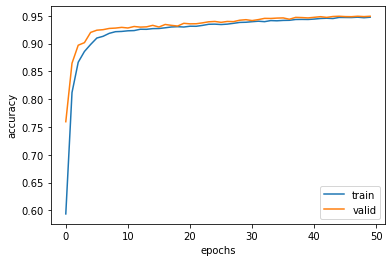

In [11]:
# add history of accuracy and validation accuracy to the plot
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()

In [9]:
# see if it's good at predecting new inputs
result = first_model.evaluate(test_generator)

25/25 [==============================] - 79s 3s/step - loss: 0.1412 - auc: 0.9904 - acc: 0.9565


## 5. Making predictions

In [4]:
from keras.models import load_model
# load our saved model
first_model = load_model('first_model.h5')

In [10]:
# see if it's good at predecting new inputs
result = first_model.evaluate(test_generator)

25/25 [==============================] - 58s 2s/step - loss: 0.1408 - auc: 0.9905 - acc: 0.9562


- Confusion matrix

In [13]:
# don't stop everything if an image didn't load correctly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# defining paths for each class in the test folder
paths = ["../input/wildfire-prediction-dataset/test/nowildfire/",
         "../input/wildfire-prediction-dataset/test/wildfire/"]
# initializing a dictionary to store predictions
results = {"nwf":{0:0, 1:0},
            "wf":{0:0, 1:0}}

# load images, predict and store predictions made by the model
for path, key in zip(paths, results.keys()):
    print(f"predicting {key} images ...")
    for file in os.listdir(path):
        img = tf.keras.utils.load_img(
            (path + file), target_size=(350, 350)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array = img_array / 255.0
        prediction = first_model.predict(img_array, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results

predicting nwf images ...
predicting wf images ...


{'nwf': {0: 2691, 1: 129}, 'wf': {0: 147, 1: 3333}}

In [14]:
# convert the dictionary to a dataframe for better representation
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["nwf"][0] + df["wf"][1]) / 6300 * 100))

print("No wildfire detection accuracy is : {:.2f}%".format(df["nwf"][0] / df["nwf"].sum() * 100))
print("Wildfire detection accuracy is : {:.2f}%".format(df["wf"][1] / df["wf"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()

Overall accuracy is : 95.62%

No wildfire detection accuracy is : 95.43%
Wildfire detection accuracy is : 95.78%

Confusion Matrix :


,0,1
nwf,2691,129
wf,147,3333


- Predict for one picture

This area is at risk of wildfire. 44.8171095 , -122.2012416


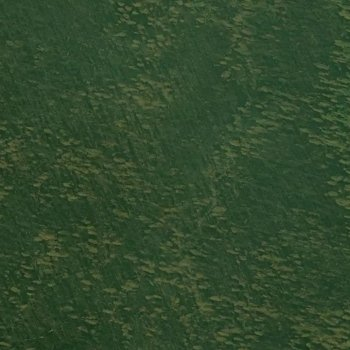

In [15]:
import requests
import urllib
import PIL
from io import BytesIO

# define the image's path
lat = input("Enter a latitude : ")
lon = input("Enter a longitude : ")
center = lon + ',' + lat

# URL
api_key = open('api_key_mapbox.txt', 'r').read()
img_size = '350x350'
img_format = '.jpg'
zoom = '15'

base_link = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/'
token = '?access_token='
extra =  '&logo=false&attribution=false'
rest = ',' + zoom + ',0/' + img_size + token + api_key + extra

url = base_link + center + rest


# load & preprocess the image so the model can treat it properly
response = requests.get(url)
img = PIL.Image.open(BytesIO(response.content))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = img_array / 255.0

# predict with our loaded model
prediction = first_model.predict(img_array, verbose=0)

class_names = ["nowildfire", "wildfire"]

# result
if(class_names[np.argmax(prediction)] == 'wildfire'):
    print("This area is at risk of wildfire.", lat, ",", lon)
else:
    print("This area is not at risk of wildfire.", lat, ",", lon)


img